Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using DynamicHMCModels, ForwardDiff, Flux, ReverseDiff
gr(size=(400,400))

┌ Info: Recompiling stale cache file /Users/rob/.julia/compiled/v1.2/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1188
loaded
┌ Info: Recompiling stale cache file /Users/rob/.julia/compiled/v1.2/ReverseDiff/aydCy.ji for ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267]
└ @ Base loading.jl:1188


Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_d("..", "scripts", "10")
cd(ProjDir)

### snippet 10.4

In [3]:
d = CSV.read(rel_path("..", "data", "chimpanzees.csv"), delim=';');
df = convert(DataFrame, d);
df[:pulled_left] = convert(Array{Int64}, df[:pulled_left])
df[:prosoc_left] = convert(Array{Int64}, df[:prosoc_left])
df[:condition] = convert(Array{Int64}, df[:condition])
df[:actor] = convert(Array{Int64}, df[:actor])
first(df[[:actor, :pulled_left, :prosoc_left, :condition]], 5)

struct m_10_04d_model{TY <: AbstractVector, TX <: AbstractMatrix,
  TA <: AbstractVector}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Actors"
    A::TA
    "Number of observations"
    N::Int
    "Number of unique actors"
    N_actors::Int
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem::m_10_04d_model)(θ)
    @unpack y, X, A, N, N_actors = problem   # extract the data
    @unpack β, α = θ  # works on the named tuple too
    ll = 0.0
    ll += sum(logpdf.(Normal(0, 10), β)) # bp & bpC
    ll += sum(logpdf.(Normal(0, 10), α)) # alpha[1:7]
    ll += sum(
      [loglikelihood(Binomial(1, logistic(α[A[i]] + dot(X[i, :], β))), [y[i]]) for i in 1:N]
    )
    ll
end

Instantiate the model with data and inits.

In [5]:
N = size(df, 1)
N_actors = length(unique(df[:actor]))
X = hcat(ones(Int64, N), df[:prosoc_left] .* df[:condition]);
A = df[:actor]
y = df[:pulled_left]
p = m_10_04d_model(y, X, A, N, N_actors);
θ = (β = [1.0, 0.0], α = [-1.0, 10.0, -1.0, -1.0, -1.0, 0.0, 2.0])
p(θ)

-305.21943396408915

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::m_10_04d_model) =
    as( (β = as(Array, size(p.X, 2)), α = as(Array, p.N_actors), ) )
# Wrap the problem with a transformation, then use Flux for the gradient.
P = TransformedLogDensity(problem_transformation(p), p)

TransformedLogDensity of dimension 9

For stress testing

In [7]:
stresstest = false

#ad = :Flux
ad = :ForwardDiff
#ad = :ReverseDiff

if stresstest
  ∇P = ADgradient(:ForwardDiff, P);
  LogDensityProblems.stresstest(p, N=1000, scale=1.0)
else
  ∇P = LogDensityRejectErrors(ADgradient(ad, P));
end

LogDensityRejectErrors{LogDensityProblems.ForwardDiffLogDensity{TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##420.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}},ForwardDiff.GradientConfig{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##420.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}}},Float64},Float64,9,Array{ForwardDiff.Dual{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{Trans

Run N chains

In [8]:
N = 1
posterior = Vector{Array{NamedTuple{(:β, :α),Tuple{Array{Float64,1},
  Array{Float64,1}}},1}}(undef, N)

for i in 1:N
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
  posterior[i] = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
end

MCMC, adapting ϵ (75 steps)
0.012 s/step ...done
MCMC, adapting ϵ (25 steps)
0.017 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0063 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0061 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0041 s/step ...done
MCMC, adapting ϵ (400 steps)
step 350 (of 400), 0.0029 s/step
0.0028 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0033 s/step ...done
MCMC (1000 steps)
step 335 (of 1000), 0.003 s/step
step 651 (of 1000), 0.0031 s/step
step 972 (of 1000), 0.0031 s/step
0.0031 s/step ...done


Result rethinking

In [9]:
rethinking = "
      mean   sd  5.5% 94.5% n_eff Rhat
a[1] -0.74 0.27 -1.19 -0.31  2899    1
a[2] 10.77 5.20  4.60 20.45  1916    1
a[3] -1.05 0.28 -1.50 -0.62  3146    1
a[4] -1.05 0.28 -1.50 -0.61  3525    1
a[5] -0.73 0.28 -1.17 -0.28  3637    1
a[6]  0.22 0.27 -0.21  0.67  3496    1
a[7]  1.82 0.41  1.21  2.50  3202    1
bp    0.83 0.27  0.42  1.27  2070    1
bpC  -0.13 0.31 -0.62  0.34  3430    1
";

Set varable names

In [10]:
parameter_names = ["bp", "bpC"]
pooled_parameter_names = ["a_1", "a_2", "a_3", "a_4", "a_5", "a_6", "a_7"]

7-element Array{String,1}:
 "a_1"
 "a_2"
 "a_3"
 "a_4"
 "a_5"
 "a_6"
 "a_7"

Create a3d

In [11]:
a3d = Array{Float64, 3}(undef, 1000, 9, N);
for j in 1:N
  for i in 1:1000
    a3d[i, 1:2, j] = values(posterior[j][i][1])
    a3d[i, 3:9, j] = values(posterior[j][i][2])
  end
end

chns = MCMCChains.Chains(a3d,
  Symbol.(vcat(parameter_names, pooled_parameter_names)),
  Dict(
    :parameters => Symbol.(parameter_names),
    :pooled => Symbol.(pooled_parameter_names)
  )
);

Describe the chain

In [12]:
describe(chns)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = bp, bpC

Empirical Posterior Estimates
───────────────────────────────────────────
parameters
     Mean    SD   Naive SE  MCSE     ESS   
 bp 1.3896 3.6705   0.1161 0.1621  512.5593
bpC 0.4120 0.2578   0.0082 0.0075 1000.0000

Quantiles
───────────────────────────────────────────
parameters
      2.5%   25.0%   50.0%  75.0%  97.5% 
 bp -8.6782 -1.2742 1.4199 4.1184 13.0727
bpC -0.4990  0.2427 0.4106 0.5869  1.1401



Describe the chain

In [13]:
describe(chns, section=:pooled)

Log evidence      = 0.0
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
pooled            = a_1, a_2, a_3, a_4, a_5, a_6, a_7

Empirical Posterior Estimates
────────────────────────────────────────────
pooled
      Mean    SD   Naive SE  MCSE     ESS   
a_1 -1.8385 3.6927   0.1168 0.1640  507.2841
a_2 10.6151 6.3188   0.1998 0.1876 1000.0000
a_3 -2.1340 3.6785   0.1163 0.1617  517.3104
a_4 -2.1282 3.6740   0.1162 0.1628  509.3730
a_5 -1.8276 3.6820   0.1164 0.1640  504.1404
a_6 -0.9090 3.6780   0.1163 0.1629  509.9332
a_7  0.6574 3.7264   0.1178 0.1610  535.3980

Quantiles
────────────────────────────────────────────
pooled
      2.5%    25.0%   50.0%   75.0%   97.5% 
a_1 -13.6660 -4.5090 -1.8157  0.8443  8.5400
a_2  -3.8212  5.9983 10.0417 14.4440 34.8040
a_3 -14.4443 -4.8456 -2.1467  0.5275  8.1012
a_4 -14.4973 -4.7586 -2.1088  0.4568  7.9939
a_5 -13.7203 -4.5691 -1.8418  0.8459  8.5508
a_6 -12.6666 -3.5540 -0.9330  1.8121  9.2808
a_7 -

Plot the chain parameters

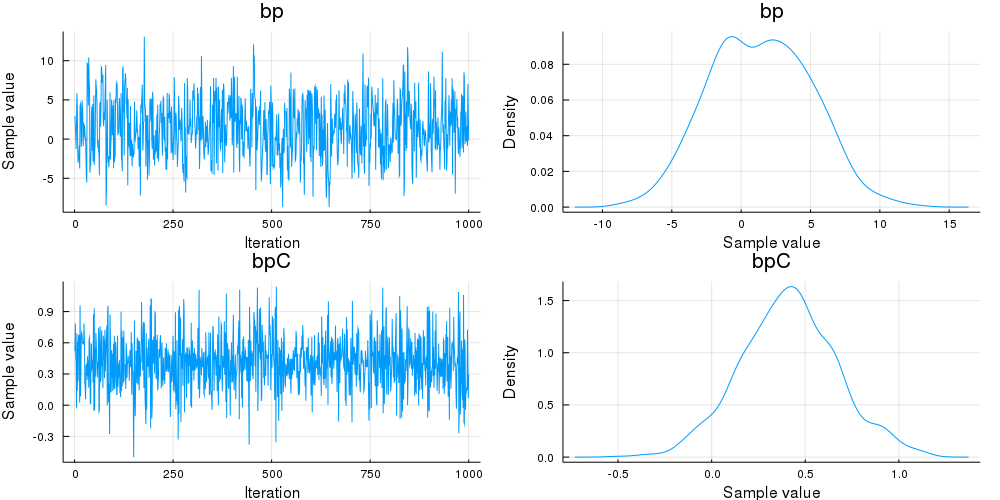

In [14]:
plot(chns)

Plot the chain pooled parameters

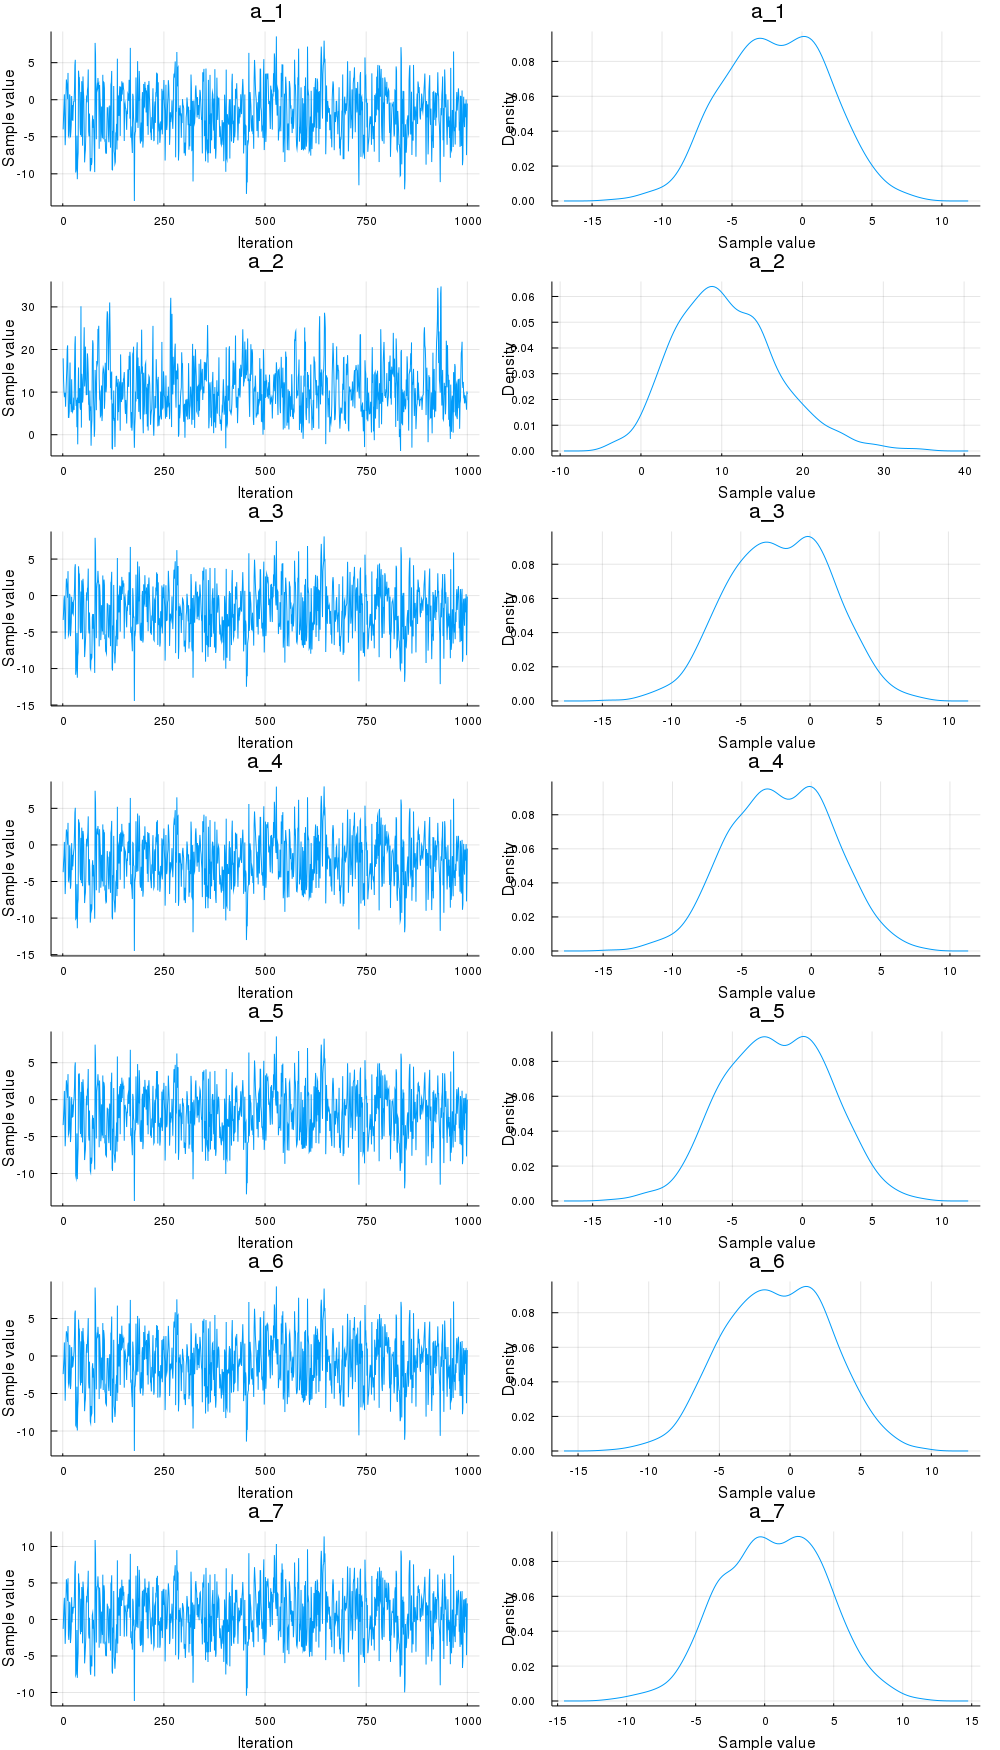

In [15]:
plot(chns, section=:pooled)

End of `m10.04d1.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*